In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv("orders.csv.zip", sep="|")

In [3]:
orders['time'] = pd.to_datetime(orders['time'])
orders['orderValue'] = orders['order'] * orders['salesPrice']

In [4]:
orders['itemID'].value_counts()

itemID
5035    8973
5117    8063
7789    7415
5122    6442
5139    5407
        ... 
5394       1
7530       1
6432       1
8645       1
7176       1
Name: count, Length: 9840, dtype: int64

In [5]:
orders

,time,transactID,itemID,order,salesPrice,orderValue
0,2018-01-01 00:01:56,2278968,450,1,17.42,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47,40.94
3,2018-01-01 00:09:24,2278968,450,1,17.42,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19,5.19
...,...,...,...,...,...,...
2181950,2018-06-29 23:54:22,2040347,9217,1,23.50,23.50
2181951,2018-06-29 23:55:09,2260943,2175,1,11.60,11.60
2181952,2018-06-29 23:55:09,2260943,2061,1,1.03,1.03
2181953,2018-06-29 23:55:09,2260943,2195,1,18.73,18.73


In [6]:
total_orders = orders.groupby([orders['time'].dt.date, orders['itemID']])['order'].sum().unstack(1)
total_values = orders.groupby([orders['time'].dt.date, orders['itemID']])['orderValue'].sum().unstack(1)

In [7]:
total_orders.fillna(0, inplace=True)
total_values.fillna(0, inplace=True)

In [8]:
for k, df in orders.groupby(by='itemID'):
    s1 = df['orderValue'].sum()
    s2 = total_values[k].sum()
    if np.isclose(s1, s2, rtol=1e-9):
        continue
    raise Exception(f"Uneven sums for {k}: {s1} != {s2}")

In [9]:
stuff = pd.DataFrame({
    'total value': total_values.sum(),
    'N. days had sales': (total_values != 0).sum()
})
stuff['average value sell day'] = stuff['total value'] / stuff['N. days had sales']
stuff.corr()

,total value,N. days had sales,average value sell day
total value,1.000000,0.326009,0.483055
N. days had sales,0.326009,1.000000,-0.140865
average value sell day,0.483055,-0.140865,1.000000


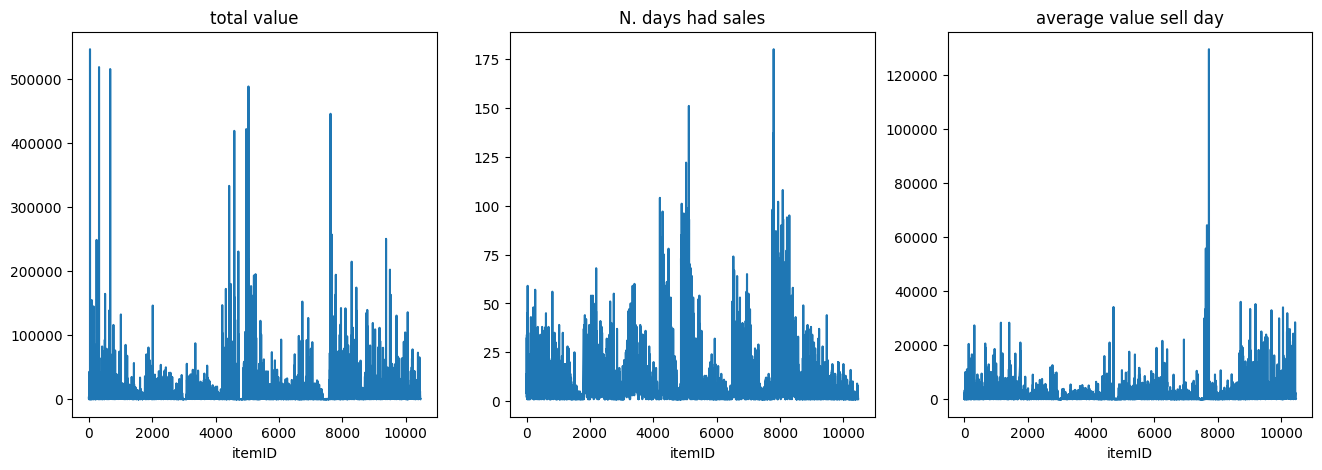

In [10]:
_, axs = plt.subplots(1, 3, figsize=(16, 5))
for a, c in zip(axs, stuff.columns):
    stuff[c].plot(ax=a, title=c) 

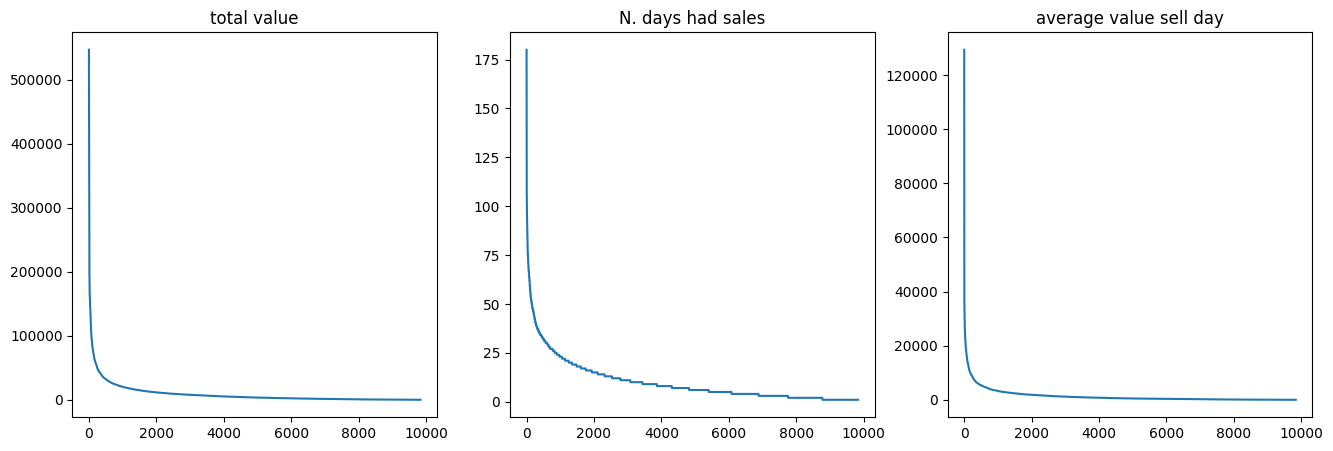

In [11]:
_, axs = plt.subplots(1, 3, figsize=(16, 5))
for a, c in zip(axs, stuff.columns):
    a.plot(stuff[c].sort_values(ascending=False).values)
    a.set_title(c)

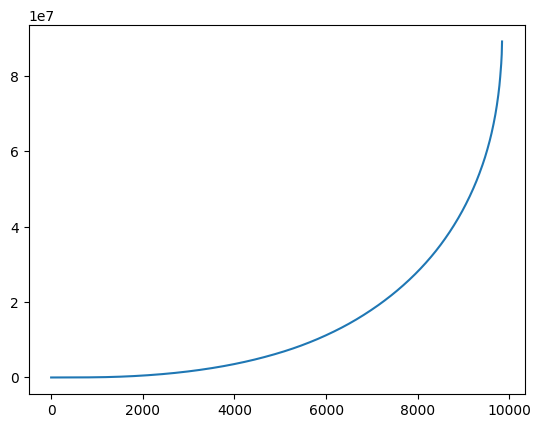

In [12]:
plt.plot(np.cumsum(stuff['total value'].sort_values().values))

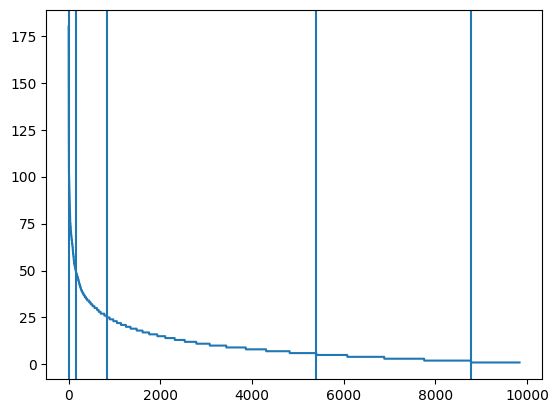

In [13]:
plt.plot(stuff['N. days had sales'].sort_values(ascending=False).values)

# for i in [1, 5] + list(range(10, 180, 10)):
for i in [1, 5, 25, 50, 100]:
    j = np.argmin(stuff['N. days had sales'].sort_values(ascending=False).values > i)
    plt.axvline(j)

<Axes: xlabel='time'>

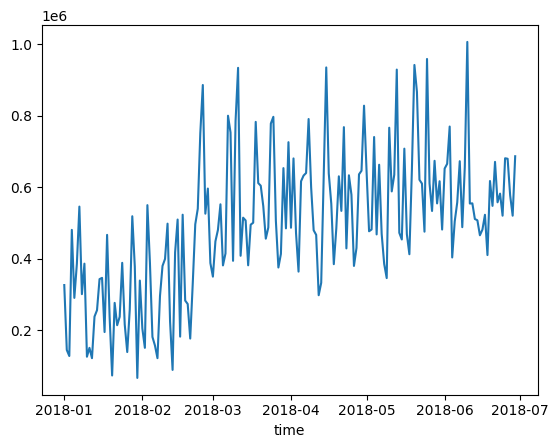

In [14]:
total_values.sum(axis=1).plot()

<Axes: xlabel='time'>

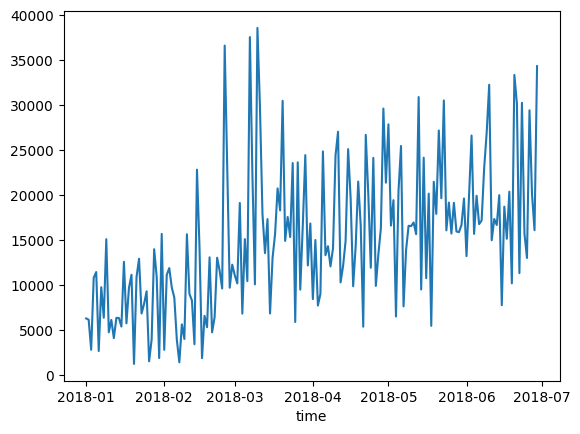

In [15]:
total_orders.sum(axis=1).plot()

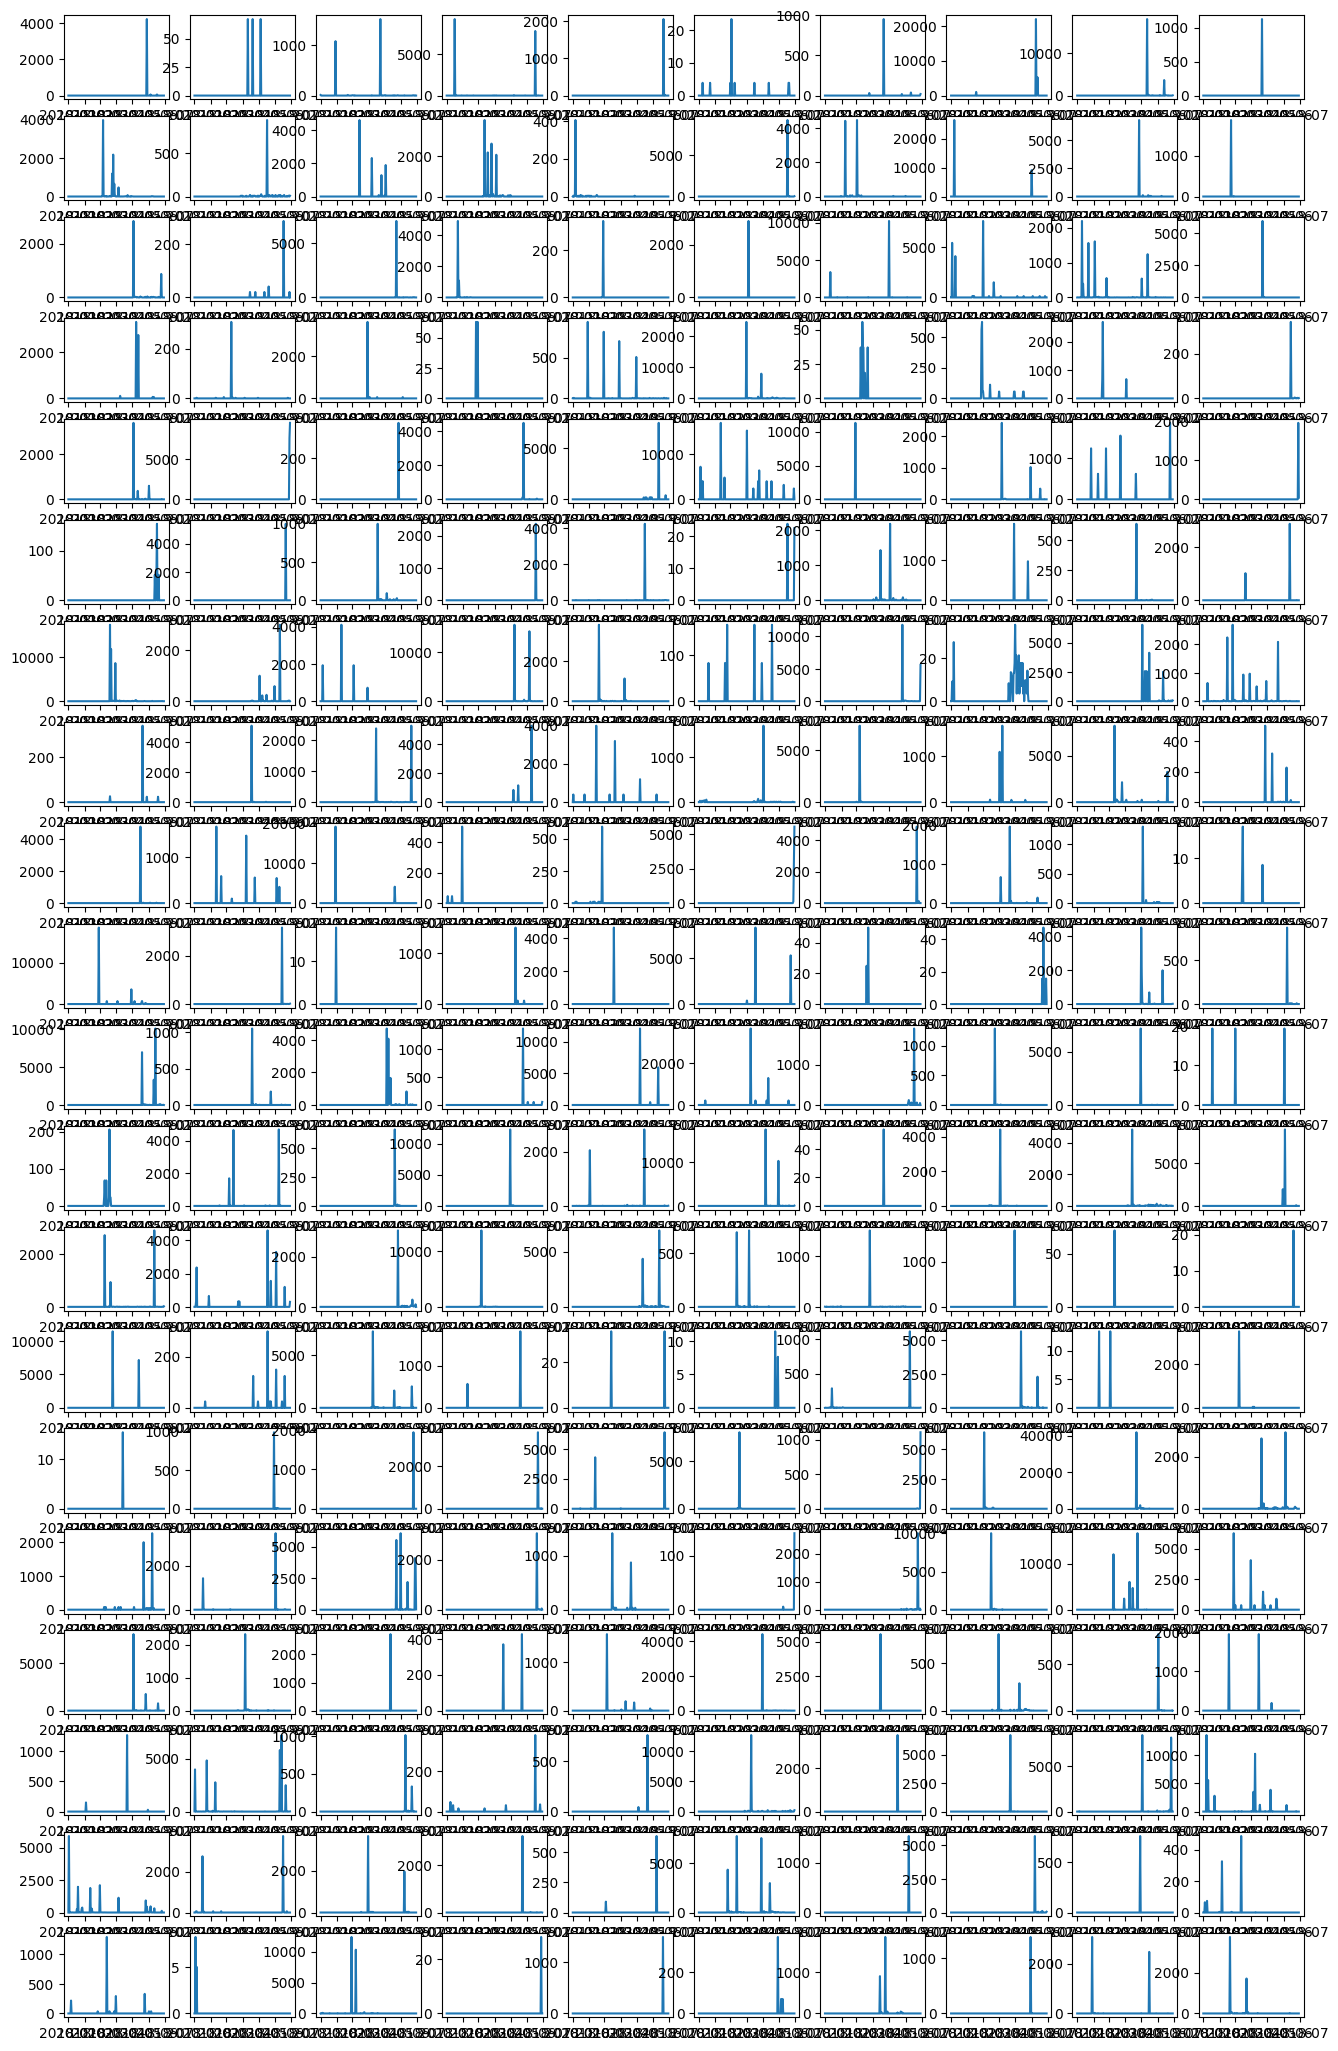

In [16]:
np.random.seed(42)
_, axs = plt.subplots(20, 10, figsize=(16,26))
axs = axs.flatten()
for a, i in zip(axs, np.random.permutation(len(total_values.columns))[:200]):
    c = total_values.columns[i]
    a.plot(total_values[c])

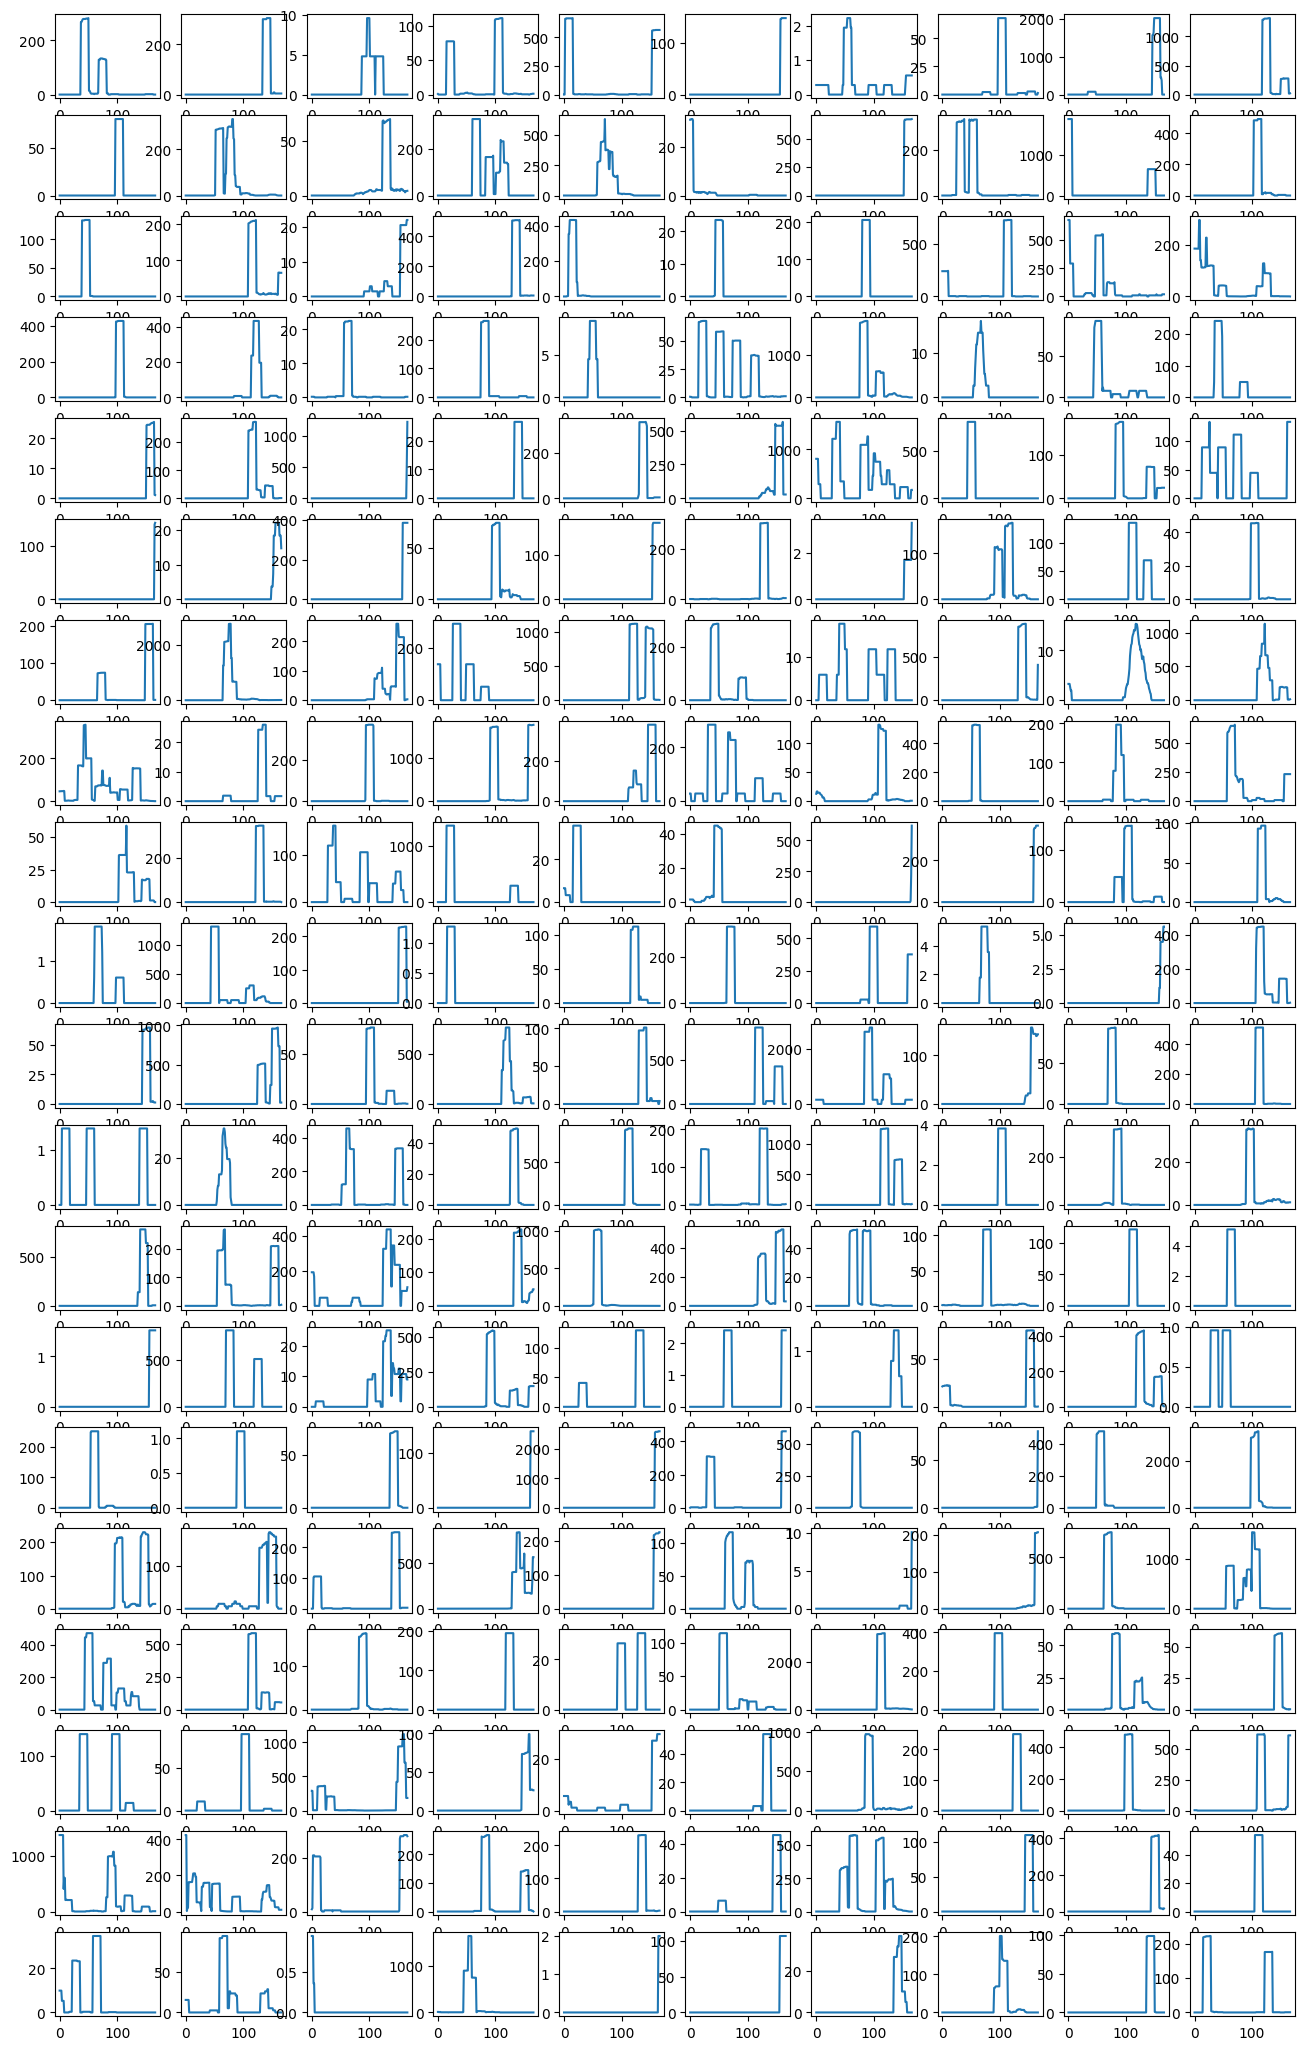

In [17]:
np.random.seed(42)
_, axs = plt.subplots(20, 10, figsize=(16, 26))
axs = axs.flatten()
for a, i in zip(axs, np.random.permutation(len(total_values.columns))[:200]):
    ma = total_values[c].rolling(window = 14).mean().dropna()
    c = total_values.columns[i]
    a.plot(ma.values)

In [18]:
total_values.columns

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       10440, 10441, 10442, 10443, 10449, 10450, 10459, 10460, 10462, 10463],
      dtype='int64', name='itemID', length=9840)

# BASIC MODEL

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
# model = ARIMA(total_values[''], order=(2, 1, 2))
# model_fit = model.fit()
# forecast = model_fit.forecast(steps=30)